In [1]:
#library imports
import numpy as np #numpy is a math library 
import pandas as pd #pandas is a data library for manipulating information, my main library
import matplotlib as plt #equivalent to R for plotting
import seaborn as sns # a wrapper for matplot lib that makes automatically pretty graphs
from funcsLibPrep import * # this is a custom set of functions, primarily for dealing with applied biosystems data
from scipy import stats # for linear regression later
from scipy import optimize # for polynomials
## stats.gmean for exponential data!!

In [2]:
#display magic for seaborn and mpl
%matplotlib inline
# %pylab inline
# %matplotlib
sns.set(context="talk") #set seaborn graphs to be pretty

# in situ PCR pilot studies (v4)

## Generally

* gauging efficiency of known number of nuclei and in situ PCR against a panel of reference genes
* reference genes with order-of-magnitude copy differences ==> "standard curve" 
    
| Gene      | Copies/genome |
| ----------- | ----------- |
| Col1A      | 2       |
| MTV   | 10        |
| 18S | 100 |
| L1 | 2500 |

## standard curves in qPCR

* a 100% efficient PCR reaction doubles in DNA quantity every cycle
* ~3 cycle difference =  1 order of magnitude difference in DNA amount

In [3]:
# additional wrapper functions for AB systems
def process(fn, data = None):
    sampleSetup = pd.read_excel(fn, 'Sample Setup', skiprows=7)
    df = importAmplification(fn).merge(sampleSetup)
    results = pd.read_excel(fn, skiprows=range(
        0, 7), sheet_name='Results').dropna(thresh=5).dropna(
            axis=1,
            thresh=5).drop(columns=['Task', 'Reporter',
                          'Quencher'])  #import results sheet, drop null rows, drop null columns, drop stupid columns
    results['Ct_clean'] = pd.to_numeric(results['Cт'], errors='coerce') #this is a cleaning line for later
    
    title = fn.rstrip('.xls')
    return df, results, title

# V4 controls

In [4]:
fn = '200812_Kl-insituPCR-geneStdCurve-v4.xls'
df, results, title = process(fn)
controlNames = ['NTC', '.05 ng (low)', '.5 ng (high)']
tip_order = ['P10', 'P20', 'P300', 'P1000']
df['SampleName'] = pd.Categorical(df['Sample Name'], controlNames + tip_order)
results['SampleName'] = pd.Categorical(results['Sample Name'], controlNames + tip_order, ordered = True)

controlData = df[df['Sample Name'].isin(controlNames)]


Text(0.4, 1, 'v4 controls, by sample')

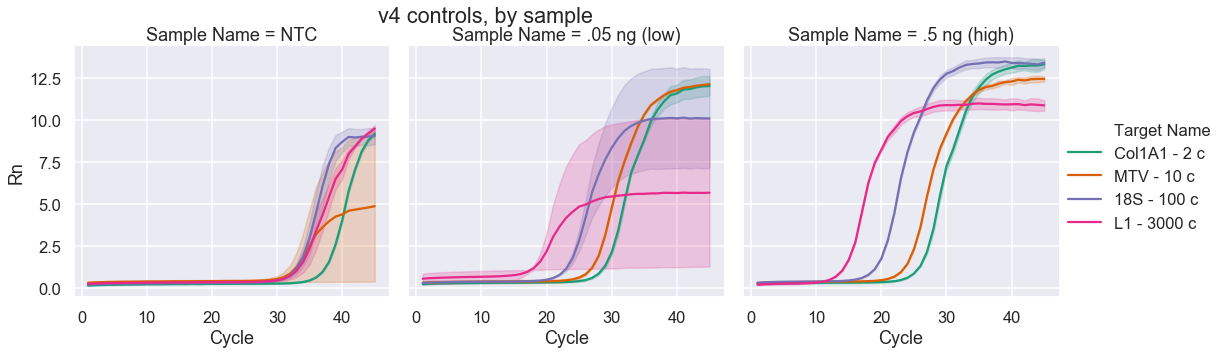

In [5]:
g = sns.relplot(x='Cycle',
                y='Rn',
                hue="Target Name",
                col="Sample Name",
                col_wrap = 3,
                data=controlData,
                palette='Dark2',
                kind="line")
g.fig.suptitle("v4 controls, by sample", x=0.4,
               y=1)  # titling graphs is helpful

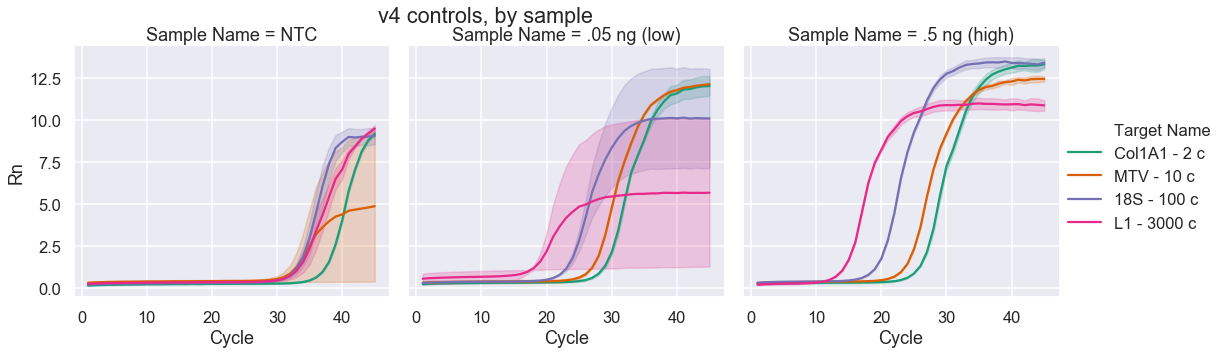

In [6]:
g.fig

Text(0.5, 1.03, 'v4, control curves by Target')

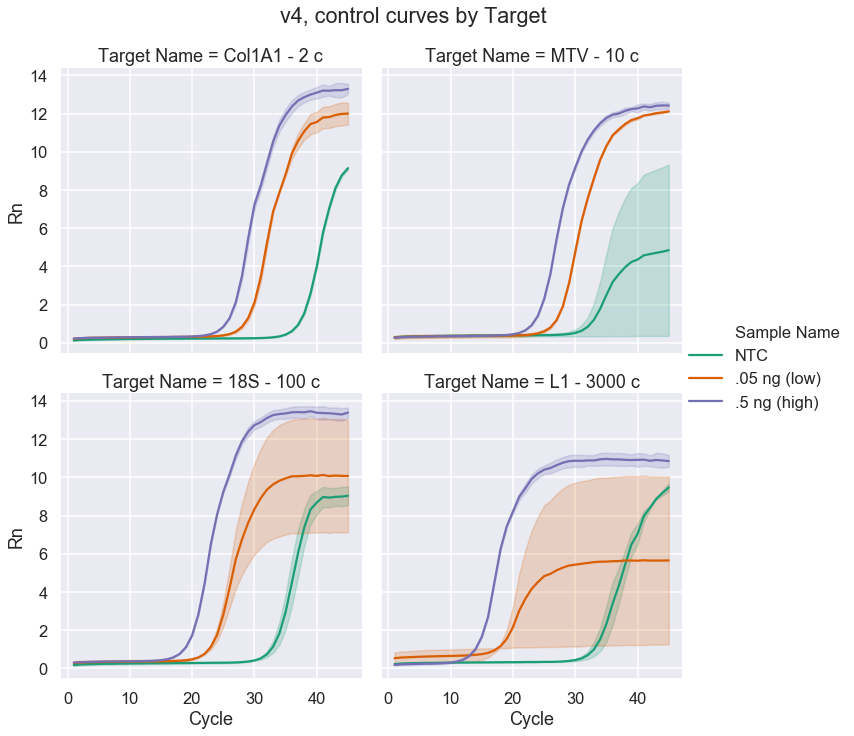

In [7]:
g = sns.relplot(x='Cycle',
                y='Rn',
                hue="Sample Name",
                col="Target Name",
                col_wrap=2,
                data=controlData,
                palette='Dark2',
                kind="line")
g.fig.suptitle("v4, control curves by Target", x = .5, y = 1.03)  

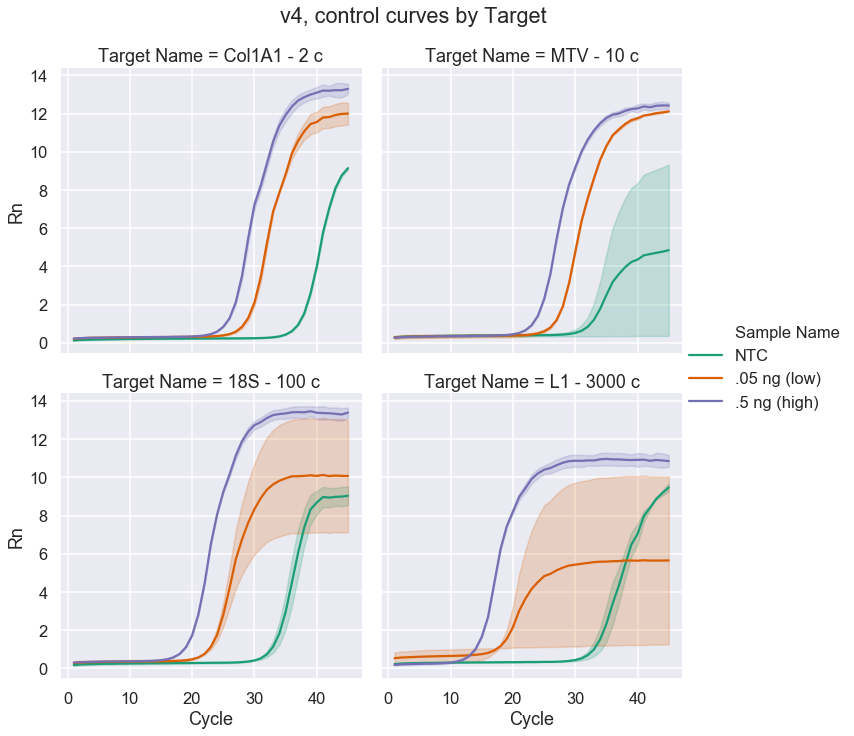

In [8]:
g.fig

In [9]:
# we know L1 works, so dropping it from the wflow
limitedDF = df.query("~`Target Name`.str.contains('L1')")
limitedResults = results.query("~`Target Name`.str.contains('L1')")

Text(0.4, 1.03, 'v4, all curves by target, sans L1')

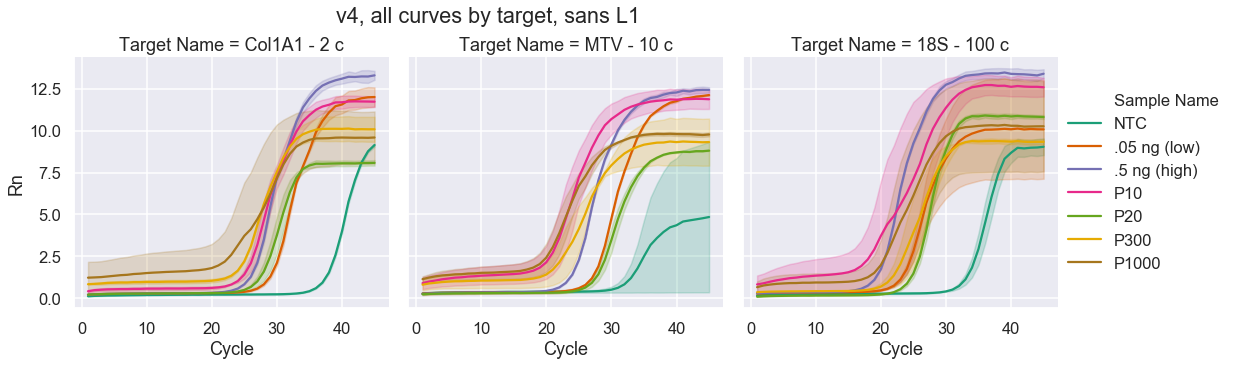

In [10]:
g = sns.relplot(x='Cycle',
                y='Rn',
                hue="Sample Name",
                col="Target Name",
                col_wrap = 3,
                data=limitedDF,
                palette='Dark2',
                kind="line")
g.fig.suptitle("v4, all curves by target, sans L1",  x=0.4, y=1.03)

18S and MTV approximate curves with visible differences. Col1A1 seems generally to be...inefficient at all concentrations. This should go to comparison with v3.

Moving to look directly at Ct instead of just visual inspection:

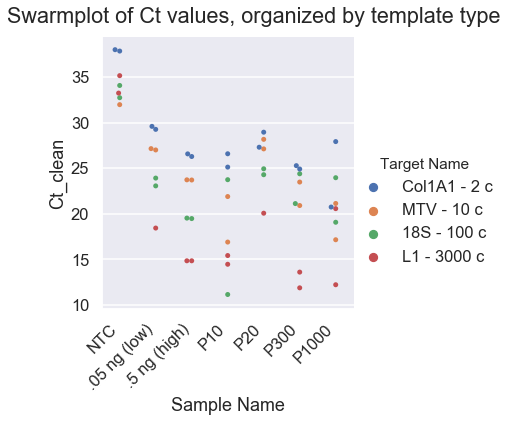

In [11]:
g = sns.catplot(x="Sample Name",
                     y="Ct_clean",
                     hue="Target Name",
                     data=results, kind = "swarm")

g.set_xticklabels(rotation=45, ha = 'right')
g.fig.suptitle("Swarmplot of Ct values, organized by template type", y = 1.03)
fig = g.fig

In [12]:
 ## looking at actual values + diffs
grp = results.groupby(['Target Name', 'SampleName'])['Ct_clean'].agg([stats.gmean, stats.gstd]) #make group
grp['diff_mean_Ct'] = grp['gmean'].transform(lambda mean: mean.diff(+1)) #show diffs between ct means. geom mean used for general analysis reasons, but doesn't make a difference here
grp = grp.reset_index().round(2)
grp

,Target Name,SampleName,gmean,gstd,diff_mean_Ct
0,18S - 100 c,NTC,33.40,1.03,NaN
1,18S - 100 c,.05 ng (low),23.49,1.03,-9.91
2,18S - 100 c,.5 ng (high),19.51,1.00,-3.98
3,18S - 100 c,P10,16.27,1.71,-3.23
4,18S - 100 c,P20,24.61,1.02,8.34
5,18S - 100 c,P300,22.70,1.11,-1.91
6,18S - 100 c,P1000,21.38,1.17,-1.32
7,Col1A1 - 2 c,NTC,37.93,1.00,16.55
8,Col1A1 - 2 c,.05 ng (low),29.43,1.01,-8.50
9,Col1A1 - 2 c,.5 ng (high),26.43,1.01,-3.00


In [13]:
# # sns.boxplot(x = "Target Name", y = "diff_previous", data = grp)
# g = sns.catplot(x = "Target Name", y = 'diff_previous', data = grp, kind = "boxen")
# g.set_xticklabels(rotation=45, ha = 'right')


# Nuclei and nanograms
* our reference template is extracted genomic DNA of a knowable ng/ul
* the # of nuclei in each is approximately:
  * n ng DNA * (1000 pg/1 ng) * (1 nuclei/6pg) = # nuclei
* this can be inverted

In [14]:
# wrapper functions for nuclei <-> ng conversions
def ng_to_nuclei(ng):
    return ng * 1000 / 6
def nuclei_to_ng(nuclei):
    return  nuclei * 6 /1000

## punch sizes and nuclei

In [15]:
#measurements with standard ruler, waiting on caliper batteries
tipDict = {
    "P1000": 1.1,
    "P300": 1,
    "P20": .75,
    "P10": .6
}  

# visual inspection of images, likely order of magnitude correct
area_umSq = 10000 #measured with Fiji
nuclei = 25 #hand counted, not accounting for z stacking
density = nuclei / area_umSq #math

In [16]:
punch = pd.DataFrame.from_dict(tipDict, orient="index",
                               columns=['diam_mm']).reset_index().rename(
                                   {"index": "template"},
                                   axis=1)  #convert to dataframe + clean up
punch['area_mm_sq'] = punch['diam_mm'].apply(
    lambda diam: np.pi * np.square(diam / 2))
punch['area_uM_sq'] = punch['area_mm_sq'] * np.square(
    1000)  #important to do *squared* dimensional analysis
punch['total_nuclei'] = punch['area_uM_sq'] * density
punch['ng'] = punch.total_nuclei.apply(nuclei_to_ng)
templates = {'.5 ng (high)': .5, '.05 ng (low)': .05, 'NTC': 0}
temp = pd.DataFrame.from_dict(templates, orient="index",
                              columns=['ng']).reset_index().rename(
                                  {"index": "template"}, axis=1)
temp['total_nuclei'] = temp.ng.apply(ng_to_nuclei)
templates = punch.append(temp, sort = False)

## calculated approximations

In [17]:
templates.round(2) # ball park estimates for comparing to later data

,template,diam_mm,area_mm_sq,area_uM_sq,total_nuclei,ng
0,P1000,1.10,0.95,950331.78,2375.83,14.25
1,P300,1.00,0.79,785398.16,1963.50,11.78
2,P20,0.75,0.44,441786.47,1104.47,6.63
3,P10,0.60,0.28,282743.34,706.86,4.24
0,.5 ng (high),NaN,NaN,NaN,83.33,0.50
1,.05 ng (low),NaN,NaN,NaN,8.33,0.05
2,NTC,NaN,NaN,NaN,0.00,0.00


# v3: standard curves of gel punches x primers, for amplicons represented in the genome at ~standard curve amounts

In [18]:
amp, results, title = process(fn)

## All data, visualized

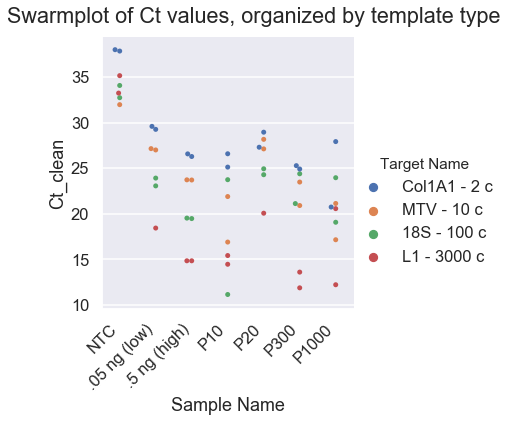

In [19]:
g.fig

## standards look like standards

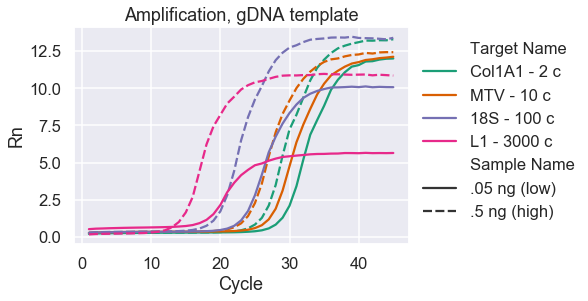

In [20]:
ax = sns.lineplot(x='Cycle',
            y='Rn',
            hue="Target Name",
                  style = "Sample Name",
            data=amp.query('`Sample Name`.str.contains("5")'),
            palette='Dark2', ci = None)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
ax.set(title = "Amplification, gDNA template")
fig = ax.get_figure()
#plotting high vs low to investigate shapes

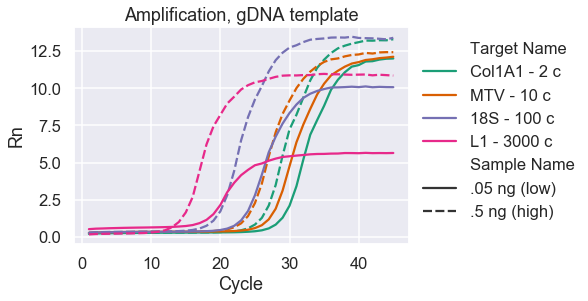

In [21]:
fig

# DIY standard curve

In [22]:
#dict for approximate values
genome_copies = {
    "col1a1": 2,
    "mtv": 10,
    "18s": 100,
    "L1": 3000,
    "L1half": 1500
}

mapping = {
    "Col1A1 - 2 c": "col1a1",
    "MTV - 10 c":"mtv",
    "18S - 100 c": '18s',
    "L1 - 3000 c": 'L1'}


In [23]:
calc = templates.add_suffix("_calc")
results['Target Name'] = results['Target Name'].map(mapping, na_action="ignore")
results['genomeCopies'] = results['Target Name'].map(genome_copies)
d = results.merge(calc, left_on = "Sample Name", right_on ="template_calc", how = "outer").rename({"Sample Name": "SampleName"}, axis=1)

In [24]:
d['num_amplicons_calc'] = d['total_nuclei_calc']*d['genomeCopies']
d['log2_num_amplicons_calc'] = np.log2(d['num_amplicons_calc'].replace(0, np.nan)).fillna(0)
d.tail()[['Well', 'SampleName', 'Target Name', 'Ct_clean', 'genomeCopies', 'num_amplicons_calc', 'log2_num_amplicons_calc']]

,Well,SampleName,Target Name,Ct_clean,genomeCopies,num_amplicons_calc,log2_num_amplicons_calc
51,F10,P1000,mtv,17.158970,10,2.375829e+04,14.536144
52,G9,P1000,18s,23.963289,100,2.375829e+05,17.858072
53,G10,P1000,18s,19.077314,100,2.375829e+05,17.858072
54,H9,P1000,L1,12.223901,3000,7.127488e+06,22.764962
55,H10,P1000,L1,20.571774,3000,7.127488e+06,22.764962


## Linear regression to standards

In [25]:
stds = d.query('SampleName.str.contains("high")')

x = stds['log2_num_amplicons_calc']
y = stds['Ct_clean']
y_range = [y.min().round(2), y.max().round()]

m, b, r_value, p_value, std_err = stats.linregress(x, y)
ct_line = m*x + b
line_eq = "y={:.2f}x+{:.2f}".format(m, b)

# considering range, not really interested in working  too far outside our range
is_ranged = d['Ct_clean'].between(y.min(), y.max())
ranged = d[is_ranged].copy()
ranged['log2_num_amplicons_curveExp'] = (ranged['Ct_clean'] - b) / m
ranged['num_amplicons_curveExp'] = np.exp2(ranged['log2_num_amplicons_curveExp'])
samples = ranged[ranged['SampleName'].isin(tip_order)]

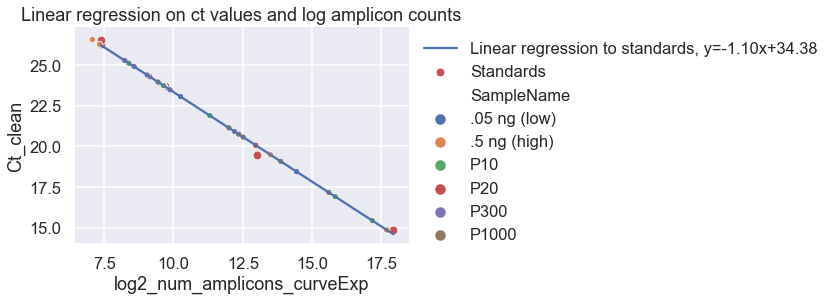

In [26]:
ax = sns.scatterplot(x, y, marker='o', label='Standards', color= "r", s= 75, alpha = 1)
ax = sns.lineplot(x,
                  ct_line,
                  label='Linear regression to standards, {}'.format(line_eq),
                  ax=ax)
ax = sns.scatterplot('log2_num_amplicons_curveExp',
                     'Ct_clean',
                     data=ranged,
                     hue="SampleName", s= 40)
# ax = sns.pointplot('log2_num_amplicons_curvecalc',
#                    'Ct_clean',
#                    data=ranged,
#                    join=False,
#                    hue='SampleName', dodge = .5, markers = "x", ax= ax)
sns.despine(ax=ax,
            top=True,
            right=True,
            left=False,
            bottom=False,
            offset=None,
            trim=False)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
ax.set(title="Linear regression on ct values and log amplicon counts")

fig = ax.get_figure()

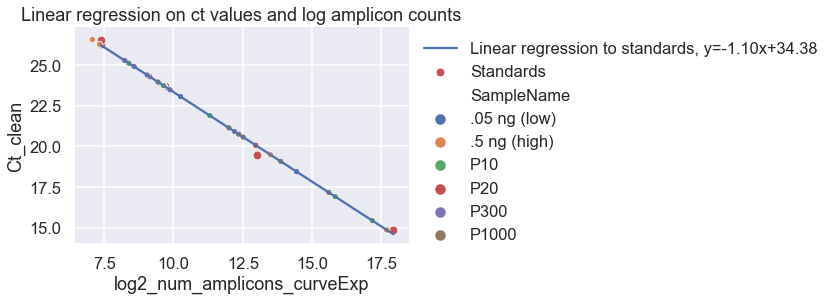

In [27]:
fig

# correlation between calculated + 'empirical'

In [28]:
# correlation between calculated and emperical
x= 'log2_num_amplicons_calc'
y= 'log2_num_amplicons_curveExp'
m, b, r_value, p_value, std_err = stats.linregress(samples[x], samples[y])
ct_line = m*ranged[x] + b
line_eq = "y={:.2f}x+{:.2f}".format(m, b)

R = 0.512344941369809


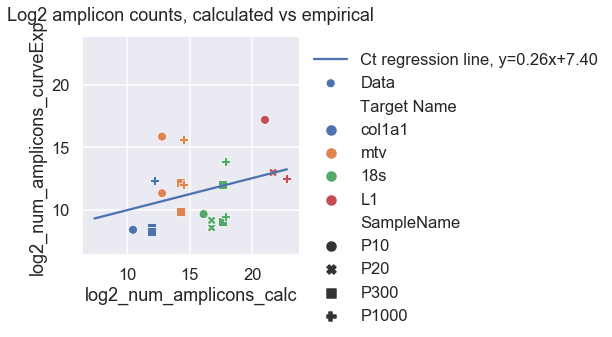

In [29]:
ax = sns.lineplot(x,
                  ct_line,
                  label='Ct regression line, {}'.format(line_eq),
                  data=ranged)
ax = sns.scatterplot(x, y, label="Data", data=samples, hue="Target Name", style = "SampleName", ax=ax)

ax.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
ax.set_title("Log2 amplicon counts, calculated vs empirical", y = 1.05)

ax.axis(xmin = ranged[x].min()-1, xmax = ranged[x].max()+1, ymin=ranged[x].min()-1,ymax=ranged[x].max()+1)
ax.set_aspect('equal', adjustable='box')
sns.despine(ax=ax,
            top=True,
            right=True,
            left=False,
            bottom=False,
            offset=None,
            trim=False)

fig = ax.get_figure()
print("R = {}".format(ranged[x].corr(ranged[y])))# ax

trend in the higher copy primers sets to have increased vertical splay. Erraticness of punch? small variation in nuclei number --> order of magnitude copy differences?

## distribution across sizes

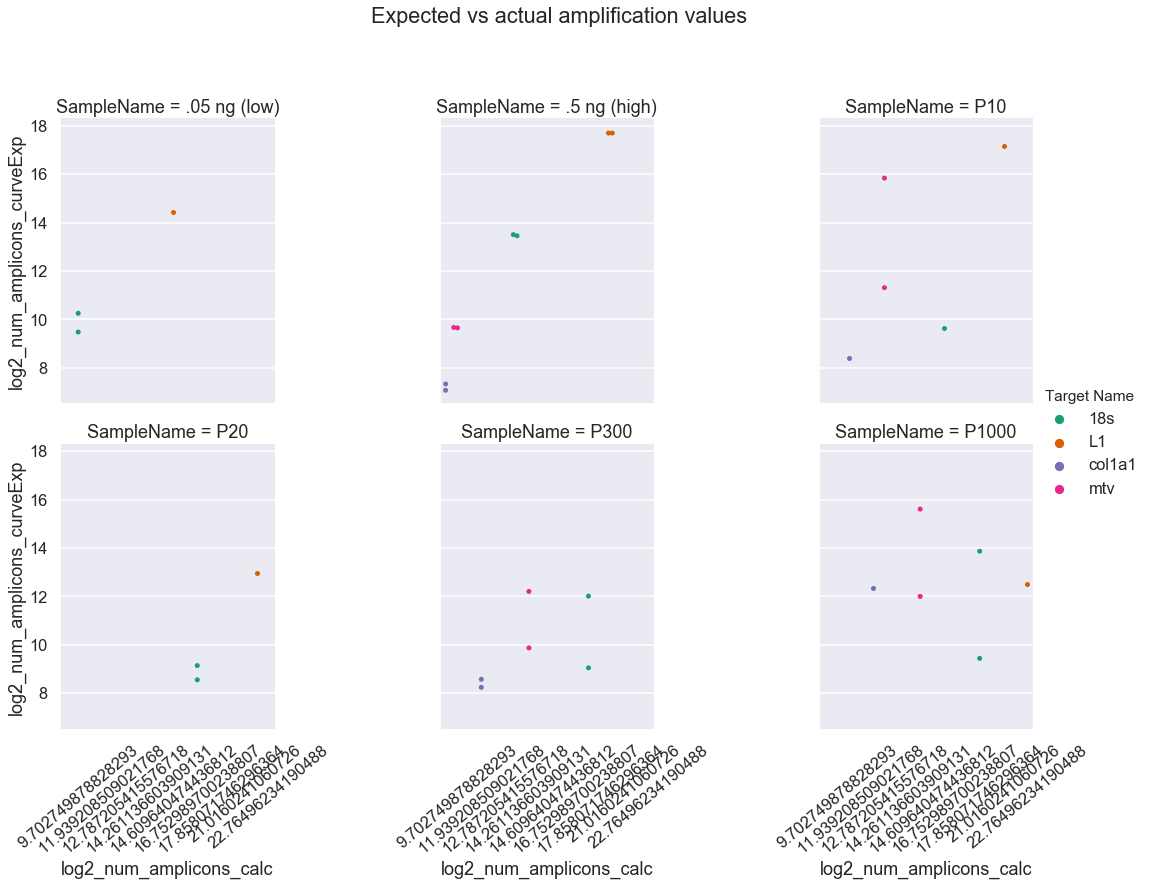

In [31]:
# not happy with these figure ticks but ok for now
g = sns.catplot(x,
                y,
                hue="Target Name",
                col="SampleName",
                col_wrap=3,
                data=ranged,
                palette='Dark2',
                kind="swarm",
                sharex=True,
                sharey=True)

g.fig.suptitle("Expected vs actual amplification values",  x=0.5, y=1.1)

# fmt = lambda x: "{:.2f}%".format(x)


for ax in g.axes.flat:
    labels = ax.get_xticklabels() # get x labels
    for i,l in enumerate(labels):
        if(i%2 == 0): labels[i] = '' # skip even labels
    ax.set_xticklabels(labels, rotation=40)